## Presentation figs

In [3]:
import os
import numpy as np
import scanpy as sc
import random

from plotnine import *
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, silhouette_score
import random
import matplotlib.pyplot as plt

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_histo = adata_histo[adata_histo.obs.in_sample]
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [4]:
adata_st.obs.section.unique().shape

(129,)

In [8]:
adata_histo.obs.image_nr.unique().shape

(130,)

In [9]:
adata_histo.obsm

AxisArraysView with keys: brain_area_onehot, brain_area_similarities, uni_embedding, uni_pca_95, uni_pca_plus_coords

## R² for kNN interpolation

In [13]:
ad_st = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/models/extended_features_2/adata_src.h5ad")
ad_histo = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/models/extended_features_2/adata_target.h5ad")
ad_st, ad_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set', 'fraction'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled', 'transformed'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set', 'fraction'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

In [17]:
histo_points = ad_histo.obs.loc[:, ("x_st", "y_st", "z_st")].to_numpy()
st_points = ad_st.obs.loc[:, ("x_st", "y_st", "z_st")].to_numpy()

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
nn.fit(ad_histo.obsm["uni_pca_plus_coords"])
_, ind_trans = nn.kneighbors(ad_st.obsm["transformed"])

# Flatten to get simple 1D arrays
ind_trans = ind_trans.flatten()
r2_score(st_points, histo_points[ind_trans])

-0.038676111607927166

In [18]:
nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
nn.fit(histo_points)
dist_coords, ind_coords = nn.kneighbors(st_points)

# Flatten to get simple 1D arrays
ind_coords = ind_coords.flatten()
dist_coords = dist_coords.flatten()
np.mean(dist_coords)

np.float64(0.11397089101830145)

## Plot actual nearest neighbors

In [20]:
ad_st.obs.section

0        1.079
1        1.079
2        1.079
3        1.079
4        1.079
         ...  
49995    1.034
49996    1.034
49997    1.034
49998    1.034
49999    1.034
Name: section, Length: 50000, dtype: float64

In [77]:
slide_ind = np.arange(25_000, 25_005)
ind_slide_trans = ind_trans[slide_ind]
slide_actual = st_points[slide_ind, :]
slide_trans = histo_points[ind_slide_trans, :]
print(r2_score(slide_actual, slide_trans))

-638.9674096607265


In [96]:
df1 = pd.DataFrame(slide_trans, columns = ("x", "y", "z")).assign(p = np.arange(5)).assign(neighbor = True)
df2 = pd.DataFrame(slide_actual, columns = ("x", "y", "z")).assign(p = np.arange(5)).assign(neighbor = False)
df_plot = pd.concat((df1, df2)).reset_index()
df_plot.p = df_plot.p.astype(str)
df_plot = df_plot[df_plot.p != "1"]
df_plot

,index,x,y,z,p,neighbor
0,0,6.411370,7.078350,5.049861,0,True
2,2,7.727043,6.538552,4.832489,2,True
3,3,6.834540,5.686380,2.318352,3,True
4,4,4.373623,7.193127,3.868525,4,True
5,0,6.171300,6.977984,5.738233,0,False
7,2,6.097870,5.788896,4.137749,2,False
8,3,6.088197,5.047220,5.829441,3,False
9,4,6.133983,5.313998,3.478164,4,False


In [88]:
arr1 = np.vstack((slide_actual, slide_trans))
min_bounds = np.min(arr1, axis=0)  # [min_x, min_y, min_z]
max_bounds = np.max(arr1, axis=0)  # [max_x, max_y, max_z]

# Filter arr2: keep points where all coordinates are within bounds
mask = np.all((histo_points >= min_bounds) & (histo_points <= max_bounds), axis=1)
f = histo_points[mask]
f.shape

(4592, 3)

In [89]:
df_bg = pd.DataFrame(f, columns = ("x", "y", "z"))
df_bg

,x,y,z
0,7.484603,5.061603,3.800399
1,7.490493,5.053774,3.973881
2,7.498435,5.159361,4.609314
3,7.500026,5.196240,4.790952
4,7.518624,5.144937,5.246877
...,...,...,...
4587,6.060273,7.022083,5.229067
4588,6.078042,6.988163,5.716860
4589,5.996611,7.119011,3.396457
4590,6.041582,7.166283,5.091142


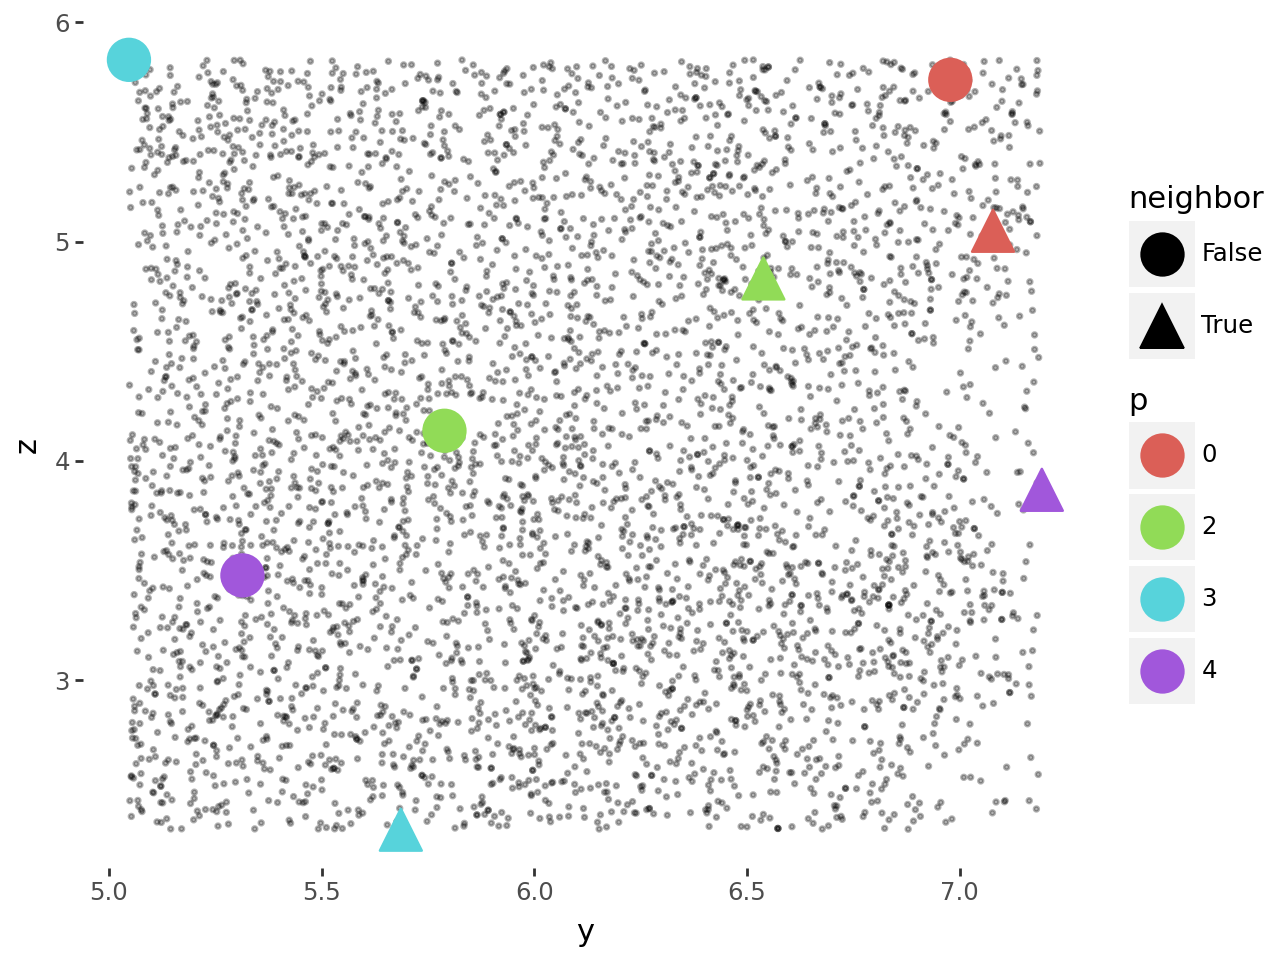

In [98]:
ggplot(df_plot, aes(x = "y", y="z", color = "p")) + geom_point(df_bg, color="black", size = 0.5, alpha=0.3) + geom_point(aes(shape="neighbor"), size = 8) + theme(
        panel_background=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        plot_background=element_blank(),
        legend_background=element_blank(),
        legend_box_background=element_blank()
    )

In [81]:
df_plot

,index,x,y,z,point,neighbor
0,0,6.411370,7.078350,5.049861,0,True
1,1,7.727043,6.538552,4.832489,1,True
2,2,7.727043,6.538552,4.832489,2,True
3,3,6.834540,5.686380,2.318352,3,True
4,4,4.373623,7.193127,3.868525,4,True
5,0,6.171300,6.977984,5.738233,0,False
6,1,6.100153,6.260794,4.380100,1,False
7,2,6.097870,5.788896,4.137749,2,False
8,3,6.088197,5.047220,5.829441,3,False
9,4,6.133983,5.313998,3.478164,4,False


## Plot the unimodal UMAPS

Plotting UMAP


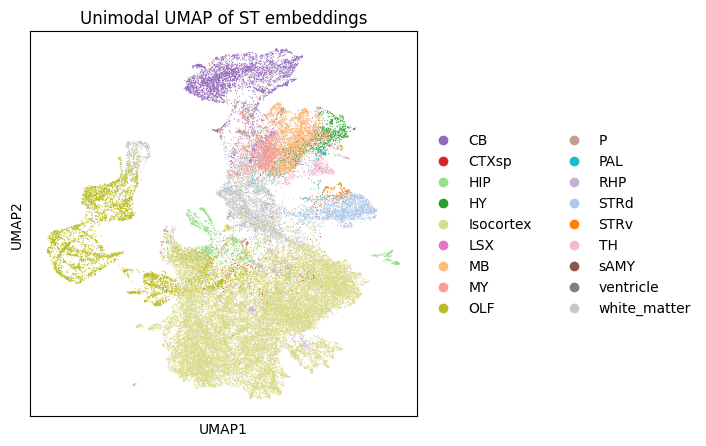

In [13]:
print("Plotting UMAP")
# Make color map
set1 = set(list(adata_st.obs["brain_area"]))
set2 = set(list(adata_histo.obs["brain_area"]))
cats = list(set1 | set2)
cmap = plt.get_cmap("tab20")
#cmap = dict(zip(cats, sc.pl.palettes.default_102[:len(cats)]))

cmap = {cat: cmap(i / len(cats)) for i, cat in enumerate(cats)}

#sc.pp.neighbors(adata_st, use_rep="pca_embedding")
#sc.tl.umap(adata_st)

fig_umap, ax = plt.subplots(1, 1, figsize=(5, 5))

sc.pl.umap(adata_st, color=["brain_area"], palette=cmap, ax=ax, show=False)
# ax.legend()
ax.set_title("Unimodal UMAP of ST embeddings")

plt.show()

In [15]:
len(cats)

19

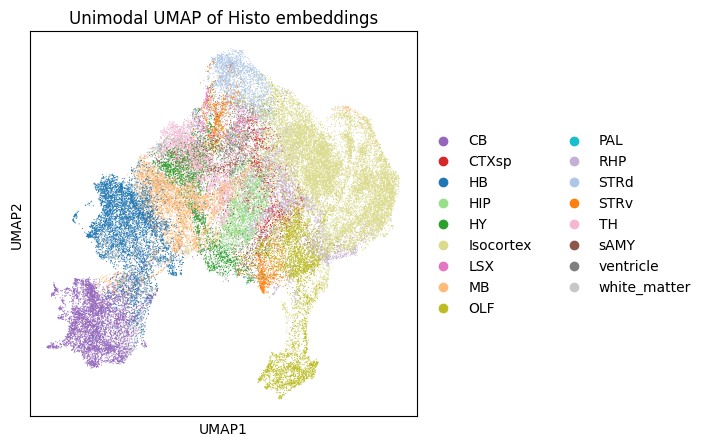

In [16]:
sc.pp.neighbors(adata_histo, use_rep="uni_pca_95")
sc.tl.umap(adata_histo)

fig_umap, ax = plt.subplots(1, 1, figsize=(5, 5))

sc.pl.umap(adata_histo, color=["brain_area"], palette=cmap, ax=ax, show=False)
ax.set_title("Unimodal UMAP of Histo embeddings")

plt.show()